In [164]:
# Import Libraries
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
# Step 1: Read Data
data = pd.read_csv('../data/Groups_finnaly.csv')
baidu = pd.read_csv('../data/baidu/baidu_2023-11-27.csv')
google = pd.read_csv('../data/google/google_2023-11-26.csv')

# Step 2: Merge and Preprocess Data
baidu = pd.merge(baidu, data, left_on='group', right_on='Translation', how='left')
baidu = baidu[['query', 'suggestion', 'category', 'group', 'English', 'completion']]
baidu = baidu.rename(columns={'English': 'group_English'})

# Step 3: Define Helper Functions
def check_suggestion_starts_with_query(row):
    return row['suggestion'].lower().startswith(row['query'].lower())

def contains_group(row):
    return row['group'].lower() in row['suggestion'].lower()

# Step 4: Apply Functions and Process Data
baidu['suggestion_starts_with_query'] = baidu.apply(check_suggestion_starts_with_query, axis=1)
google['suggestion_starts_with_query'] = google.apply(check_suggestion_starts_with_query, axis=1)
baidu['group_in_suggestion'] = baidu.apply(contains_group, axis=1)
google['group_in_suggestion'] = google.apply(contains_group, axis=1)

# Step 5: Filter Data Based on Templates
template_1 = "为什么.+(这么)"
template_2 = "(.+)为什么这么"
baidu_template_1 = baidu[baidu['query'].str.contains(re.compile(template_1))]
baidu_template_2 = baidu[baidu['query'].str.contains(re.compile(template_2))]

# Step 6: Build DataFrame for Queries
def check_unresponded_queries(main_df, comparison_df):
    unresponded_queries = set(main_df['query']) - set(comparison_df['query'])
    return main_df[main_df['query'].isin(unresponded_queries)].drop_duplicates('query').reset_index(drop=True)

templates_Chinese = ["为什么待替换词汇这么", "待替换词汇为什么这么"]
df = pd.DataFrame(columns=['query', 'category', 'group', 'English'])

group_to_english = data.set_index('Translation')['English'].to_dict()
translation_dict = data.groupby('Category')['Translation'].apply(list).to_dict()

rows = [
    {
        'query': template.replace("待替换词汇", group).replace(" ", "+"),
        'category': category,
        'group': group,
        'English': group_to_english.get(group, 'Unknown')
    }
    for category, groups in translation_dict.items()
    for group in groups
    for template in templates_Chinese
]
df = pd.DataFrame(rows)

# Step 7: Filter and Check for Unresponded Queries
template_1_pattern = templates_Chinese[0].replace("待替换词汇", ".+").replace(" ", "\+")
template_2_pattern = templates_Chinese[1].replace("待替换词汇", ".+").replace(" ", "\+")
df_template_1 = df[df['query'].str.contains(template_1_pattern, regex=True)]
df_template_2 = df[df['query'].str.contains(template_2_pattern, regex=True)]

unresponded_queries_baidu_template_1 = check_unresponded_queries(df_template_1, baidu_template_1)
unresponded_queries_baidu_template_2 = check_unresponded_queries(df_template_2, baidu_template_2)

# Step 8: Repeat for English Queries
templates_English = ["why are term_to_use so"]
df_original = pd.DataFrame(columns=['query', 'category', 'group'])

translation_dict = data.groupby('Category')['English'].apply(list).to_dict()

rows = [
    {'query': template.replace("term_to_use", group), 'category': category, 'group': group}
    for category, groups in translation_dict.items()
    for group in groups
    for template in templates_English
]
df_original = pd.DataFrame(rows)

unresponded_queries_google = check_unresponded_queries(df_original, google)
unresponded_queries_baidu_template_1 = check_unresponded_queries(df_template_1, baidu_template_1)
unresponded_queries_baidu_template_2 = check_unresponded_queries(df_template_2, baidu_template_2)


/var/folders/x1/rg74ttxx7bb0_2z1wxpb2z940000gn/T/ipykernel_1125/2198812609.py:32: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  baidu_template_1 = baidu[baidu['query'].str.contains(re.compile(template_1))]
/var/folders/x1/rg74ttxx7bb0_2z1wxpb2z940000gn/T/ipykernel_1125/2198812609.py:33: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  baidu_template_2 = baidu[baidu['query'].str.contains(re.compile(template_2))]


/Users/gengliu/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/gengliu/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/gengliu/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/gengliu/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Catego

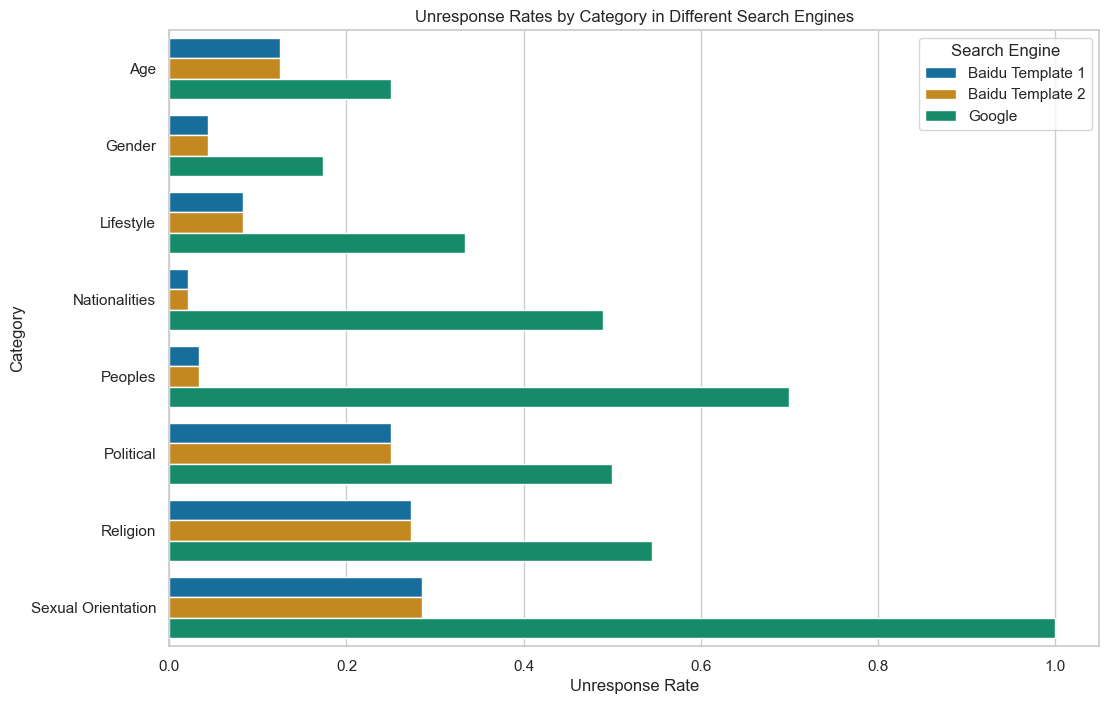

In [165]:


# Step 9: Group Data by Category
grouped_baidu_template_1 = df_template_1.groupby('category')
grouped_baidu_template_2 = df_template_2.groupby('category')
grouped_google = df_original.groupby('category')

# Step 10: Calculate Unresponded Rates for Each Category
def calculate_unresponse_rates(grouped_data, unresponded_data):
    rates = {}
    for category, group in grouped_data:
        total_queries = len(group)
        unresponded_queries = len(unresponded_data[unresponded_data['category'] == category])
        rates[category] = unresponded_queries / total_queries if total_queries > 0 else 0
    return rates

unresponse_rates_baidu_template_1 = calculate_unresponse_rates(grouped_baidu_template_1, unresponded_queries_baidu_template_1)
unresponse_rates_baidu_template_2 = calculate_unresponse_rates(grouped_baidu_template_2, unresponded_queries_baidu_template_2)
unresponse_rates_google = calculate_unresponse_rates(grouped_google, unresponded_queries_google)

# Step 11: Prepare Data for Plotting
plot_data = pd.DataFrame({
    'Category': list(unresponse_rates_baidu_template_1.keys()),
    'Baidu Template 1': list(unresponse_rates_baidu_template_1.values()),
    'Baidu Template 2': list(unresponse_rates_baidu_template_2.values()),
    'Google': list(unresponse_rates_google.values())
}).melt(id_vars='Category', var_name='Search Engine', value_name='Unresponse Rate')

# Step 12: Plot the Data
plt.figure(figsize=(12, 8))
sns.barplot(x='Unresponse Rate', y='Category', hue='Search Engine', data=plot_data)
plt.title('Unresponse Rates by Category in Different Search Engines')
plt.xlabel('Unresponse Rate')
plt.ylabel('Category')
plt.legend(title='Search Engine')
plt.show()


In [166]:
from scipy.stats import chi2_contingency

# Function to create a contingency table and perform Chi-square test
def perform_chi_square_test(category):
    # Fetching data for the specific category
    baidu_1_data = unresponded_queries_baidu_template_1[unresponded_queries_baidu_template_1['category'] == category]
    baidu_2_data = unresponded_queries_baidu_template_2[unresponded_queries_baidu_template_2['category'] == category]
    google_data = unresponded_queries_google[unresponded_queries_google['category'] == category]

    # Counting responded and unresponded queries
    total_queries_baidu_1 = len(df_template_1[df_template_1['category'] == category])
    total_queries_baidu_2 = len(df_template_2[df_template_2['category'] == category])
    total_queries_google = len(df_original[df_original['category'] == category])

    unresponded_baidu_1 = len(baidu_1_data)
    unresponded_baidu_2 = len(baidu_2_data)
    unresponded_google = len(google_data)

    responded_baidu_1 = total_queries_baidu_1 - unresponded_baidu_1
    responded_baidu_2 = total_queries_baidu_2 - unresponded_baidu_2
    responded_google = total_queries_google - unresponded_google

    # Creating contingency table
    contingency_table = [[responded_baidu_1, unresponded_baidu_1],
                         [responded_baidu_2, unresponded_baidu_2],
                         [responded_google, unresponded_google]]

    # Performing Chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    return {'Category': category, 'Chi-square': chi2, 'p-value': p, 'Degrees of Freedom': dof}

# Performing the test for each category
chi_square_results = [perform_chi_square_test(category) for category in data['Category'].unique()]

# Displaying the results
chi_square_results_df = pd.DataFrame(chi_square_results)
chi_square_results_df


,Category,Chi-square,p-value,Degrees of Freedom
0,Age,0.600000,7.408182e-01,2
1,Gender,3.285714,1.934266e-01,2
2,Lifestyle,3.600000,1.652989e-01,2
3,Political,1.500000,4.723666e-01,2
4,Peoples,46.722907,7.149071e-11,2
5,Nationalities,47.064828,6.025631e-11,2
6,Religion,2.357143,3.077180e-01,2
7,Sexual Orientation,9.545455,8.457283e-03,2


In [167]:
google.columns

Index(['query', 'suggestion', 'category', 'group', 'completion',
       'suggestion_starts_with_query', 'group_in_suggestion'],
      dtype='object')

/Users/gengliu/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/gengliu/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/gengliu/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/gengliu/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Catego

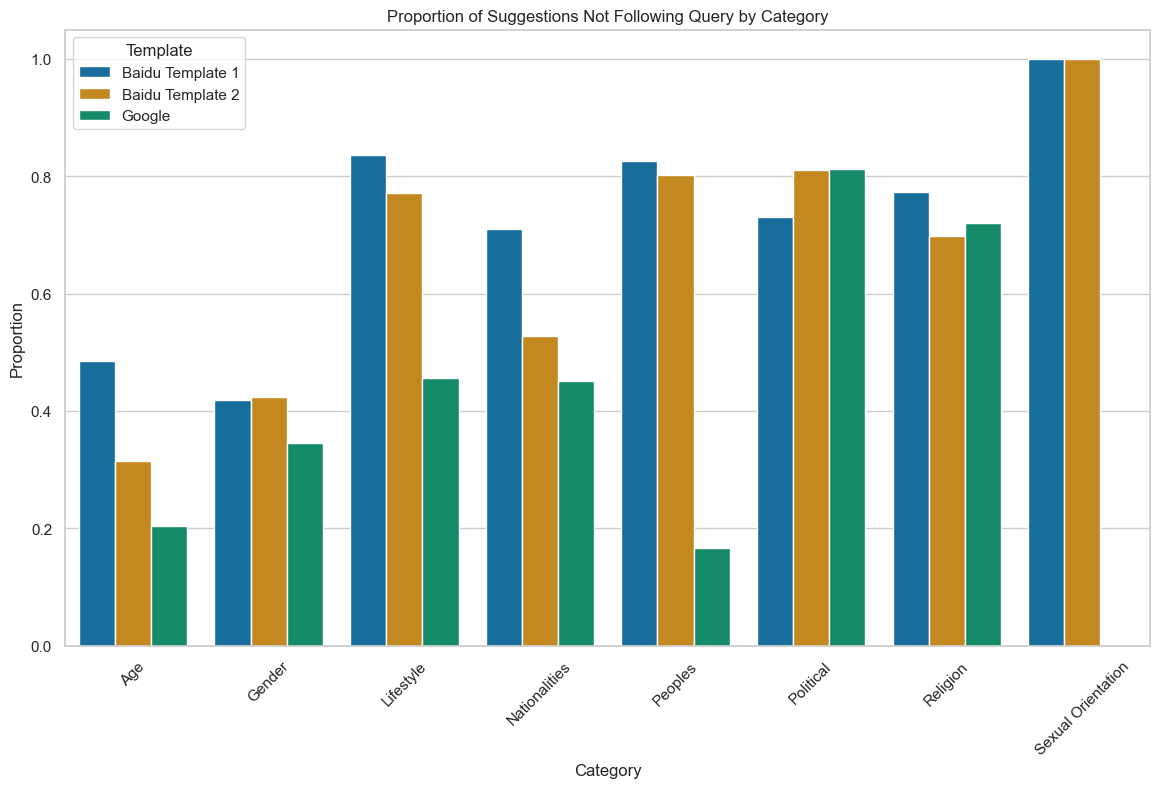

/Users/gengliu/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/gengliu/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/gengliu/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/gengliu/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Catego

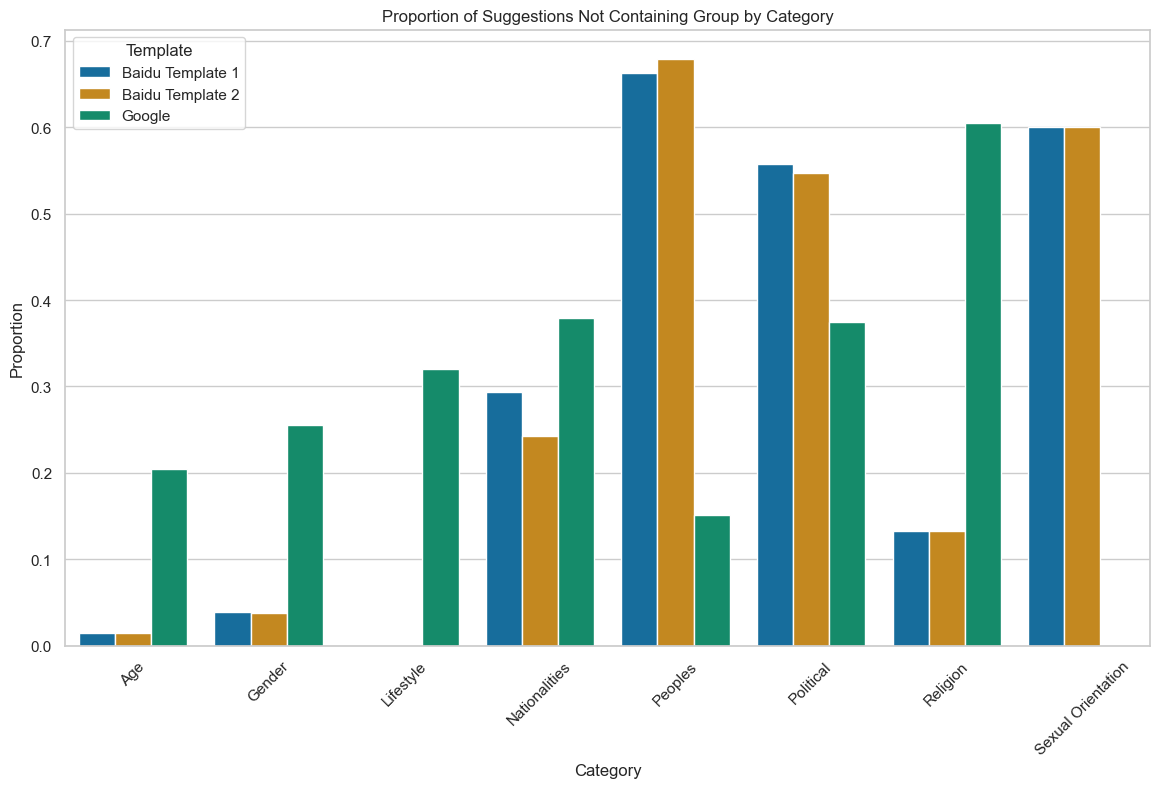

In [168]:
# Step 5: Calculate Inverse Proportions for Each Category
def calculate_category_inverse_proportions(grouped_data):
    proportions = {}
    for category, group in grouped_data:
        total = len(group)
        not_follow_query = (total - group['suggestion_starts_with_query'].sum()) / total
        not_contain_group = (total - group['group_in_suggestion'].sum()) / total
        proportions[category] = {'Not Follow Query': not_follow_query, 'Not Contain Group': not_contain_group}
    return proportions

# Group the data by category for each template and search engine
grouped_baidu_template_1 = baidu_template_1.groupby('category')
grouped_baidu_template_2 = baidu_template_2.groupby('category')
grouped_google = google.groupby('category')

# Calculate the inverse proportions
inverse_proportions_baidu_template_1 = calculate_category_inverse_proportions(grouped_baidu_template_1)
inverse_proportions_baidu_template_2 = calculate_category_inverse_proportions(grouped_baidu_template_2)
inverse_proportions_google = calculate_category_inverse_proportions(grouped_google)

# Prepare the data for plotting
plot_data = []
for category in inverse_proportions_baidu_template_1:
    plot_data.append({
        'Category': category,
        'Template': 'Baidu Template 1',
        'Not Follow Query': inverse_proportions_baidu_template_1[category]['Not Follow Query'],
        'Not Contain Group': inverse_proportions_baidu_template_1[category]['Not Contain Group']
    })

for category in inverse_proportions_baidu_template_2:
    plot_data.append({
        'Category': category,
        'Template': 'Baidu Template 2',
        'Not Follow Query': inverse_proportions_baidu_template_2[category]['Not Follow Query'],
        'Not Contain Group': inverse_proportions_baidu_template_2[category]['Not Contain Group']
    })

for category in inverse_proportions_google:
    plot_data.append({
        'Category': category,
        'Template': 'Google',
        'Not Follow Query': inverse_proportions_google[category]['Not Follow Query'],
        'Not Contain Group': inverse_proportions_google[category]['Not Contain Group']
    })

df_plot = pd.DataFrame(plot_data)

# Plot the data
plt.figure(figsize=(14, 8))
sns.barplot(x='Category', y='Not Follow Query', hue='Template', data=df_plot)
plt.title('Proportion of Suggestions Not Following Query by Category')
plt.ylabel('Proportion')
plt.xlabel('Category')
plt.xticks(rotation=45)
plt.legend(title='Template')
plt.show()

plt.figure(figsize=(14, 8))
sns.barplot(x='Category', y='Not Contain Group', hue='Template', data=df_plot)
plt.title('Proportion of Suggestions Not Containing Group by Category')
plt.ylabel('Proportion')
plt.xlabel('Category')
plt.xticks(rotation=45)
plt.legend(title='Template')
plt.show()


In [169]:
from scipy.stats import chi2_contingency

# Function to create a contingency table and perform Chi-square test
def perform_chi_square_test_for_proportion(grouped_data, proportion_key):
    chi_square_results = []
    for category in grouped_data.keys():
        # Prepare the contingency table
        contingency_table = [
            [grouped_data[category]['Baidu Template 1'][proportion_key], 
             1 - grouped_data[category]['Baidu Template 1'][proportion_key]],
            [grouped_data[category]['Baidu Template 2'][proportion_key], 
             1 - grouped_data[category]['Baidu Template 2'][proportion_key]],
            [grouped_data[category]['Google'][proportion_key], 
             1 - grouped_data[category]['Google'][proportion_key]]
        ]

        # Perform Chi-square test
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        chi_square_results.append({
            'Category': category,
            'Chi-square': chi2,
            'p-value': p,
            'Degrees of Freedom': dof
        })
    return chi_square_results

# Combining inverse proportions data for all search engines
combined_inverse_proportions = {}
for category in data['Category'].unique():
    combined_inverse_proportions[category] = {
        'Baidu Template 1': inverse_proportions_baidu_template_1.get(category, {'Not Follow Query': 0, 'Not Contain Group': 0}),
        'Baidu Template 2': inverse_proportions_baidu_template_2.get(category, {'Not Follow Query': 0, 'Not Contain Group': 0}),
        'Google': inverse_proportions_google.get(category, {'Not Follow Query': 0, 'Not Contain Group': 0})
    }

# Perform Chi-square test for "Not Follow Query"
chi_square_results_not_follow_query = perform_chi_square_test_for_proportion(combined_inverse_proportions, 'Not Follow Query')

# Perform Chi-square test for "Not Contain Group"
chi_square_results_not_contain_group = perform_chi_square_test_for_proportion(combined_inverse_proportions, 'Not Contain Group')

# Displaying the results
chi_square_results_df_not_follow_query = pd.DataFrame(chi_square_results_not_follow_query)
chi_square_results_df_not_contain_group = pd.DataFrame(chi_square_results_not_contain_group)

chi_square_results_df_not_follow_query, chi_square_results_df_not_contain_group


(             Category  Chi-square   p-value  Degrees of Freedom
 0                 Age    0.180322  0.913784                   2
 1              Gender    0.016423  0.991822                   2
 2           Lifestyle    0.386333  0.824345                   2
 3           Political    0.025999  0.987085                   2
 4             Peoples    1.162005  0.559337                   2
 5       Nationalities    0.144707  0.930202                   2
 6            Religion    0.015233  0.992412                   2
 7  Sexual Orientation    3.000000  0.223130                   2,
              Category  Chi-square   p-value  Degrees of Freedom
 0                 Age    0.336729  0.845046                   2
 1              Gender    0.319689  0.852276                   2
 2           Lifestyle    0.717391  0.698587                   2
 3           Political    0.084188  0.958780                   2
 4             Peoples    0.720568  0.697478                   2
 5       Nationalities  

In [170]:
# Create a function to integrate the metrics
def integrate_metrics(category, template, unresponse_rates, inverse_proportions):
    return {
        'Category': category,
        'Template': template,
        'Unresponse Rate': unresponse_rates.get(category, 0),
        'Not Follow Query': inverse_proportions[category]['Not Follow Query'],
        'Not Contain Group': inverse_proportions[category]['Not Contain Group']
    }

# Integrate metrics for Baidu Template 1
integrated_baidu_template_1 = [
    integrate_metrics(category, 'Baidu Template 1', unresponse_rates_baidu_template_1, inverse_proportions_baidu_template_1)
    for category in inverse_proportions_baidu_template_1
]

# Integrate metrics for Baidu Template 2
integrated_baidu_template_2 = [
    integrate_metrics(category, 'Baidu Template 2', unresponse_rates_baidu_template_2, inverse_proportions_baidu_template_2)
    for category in inverse_proportions_baidu_template_2
]


# Ensure 'Sexual Orientation' is included in inverse_proportions_google
if 'Sexual Orientation' not in inverse_proportions_google:
    # Add default values or calculate specific values for 'Sexual Orientation'
    inverse_proportions_google['Sexual Orientation'] = {'Not Follow Query': 0, 'Not Contain Group': 0}

# Integrate metrics for Google, including 'Sexual Orientation'
integrated_google = [
    integrate_metrics(category, 'Google', unresponse_rates_google, inverse_proportions_google)
    for category in unresponse_rates_google  # This ensures all categories in unresponse_rates_google are included
]


# # Integrate metrics for Google
# integrated_google = [
#     integrate_metrics(category, 'Google', unresponse_rates_google, inverse_proportions_google)
#     for category in inverse_proportions_google
# ]

# Combine into a single DataFrame
integrated_data = pd.DataFrame(integrated_baidu_template_1 + integrated_baidu_template_2 + integrated_google)

# Pivot this DataFrame to get the desired format for plotting
pivot_data = integrated_data.pivot_table(index=['Category', 'Template'], values=['Unresponse Rate', 'Not Follow Query', 'Not Contain Group'])


# Separate the integrated data by each template for plotting
data_baidu_template_1 = integrated_data[integrated_data['Template'] == 'Baidu Template 1']
data_baidu_template_2 = integrated_data[integrated_data['Template'] == 'Baidu Template 2']
data_google = integrated_data[integrated_data['Template'] == 'Google']

# Pivot the data for each template
pivot_baidu_template_1 = data_baidu_template_1.pivot_table(index='Category', values=['Unresponse Rate', 'Not Follow Query', 'Not Contain Group'])
pivot_baidu_template_2 = data_baidu_template_2.pivot_table(index='Category', values=['Unresponse Rate', 'Not Follow Query', 'Not Contain Group'])
pivot_google = data_google.pivot_table(index='Category', values=['Unresponse Rate', 'Not Follow Query', 'Not Contain Group'])




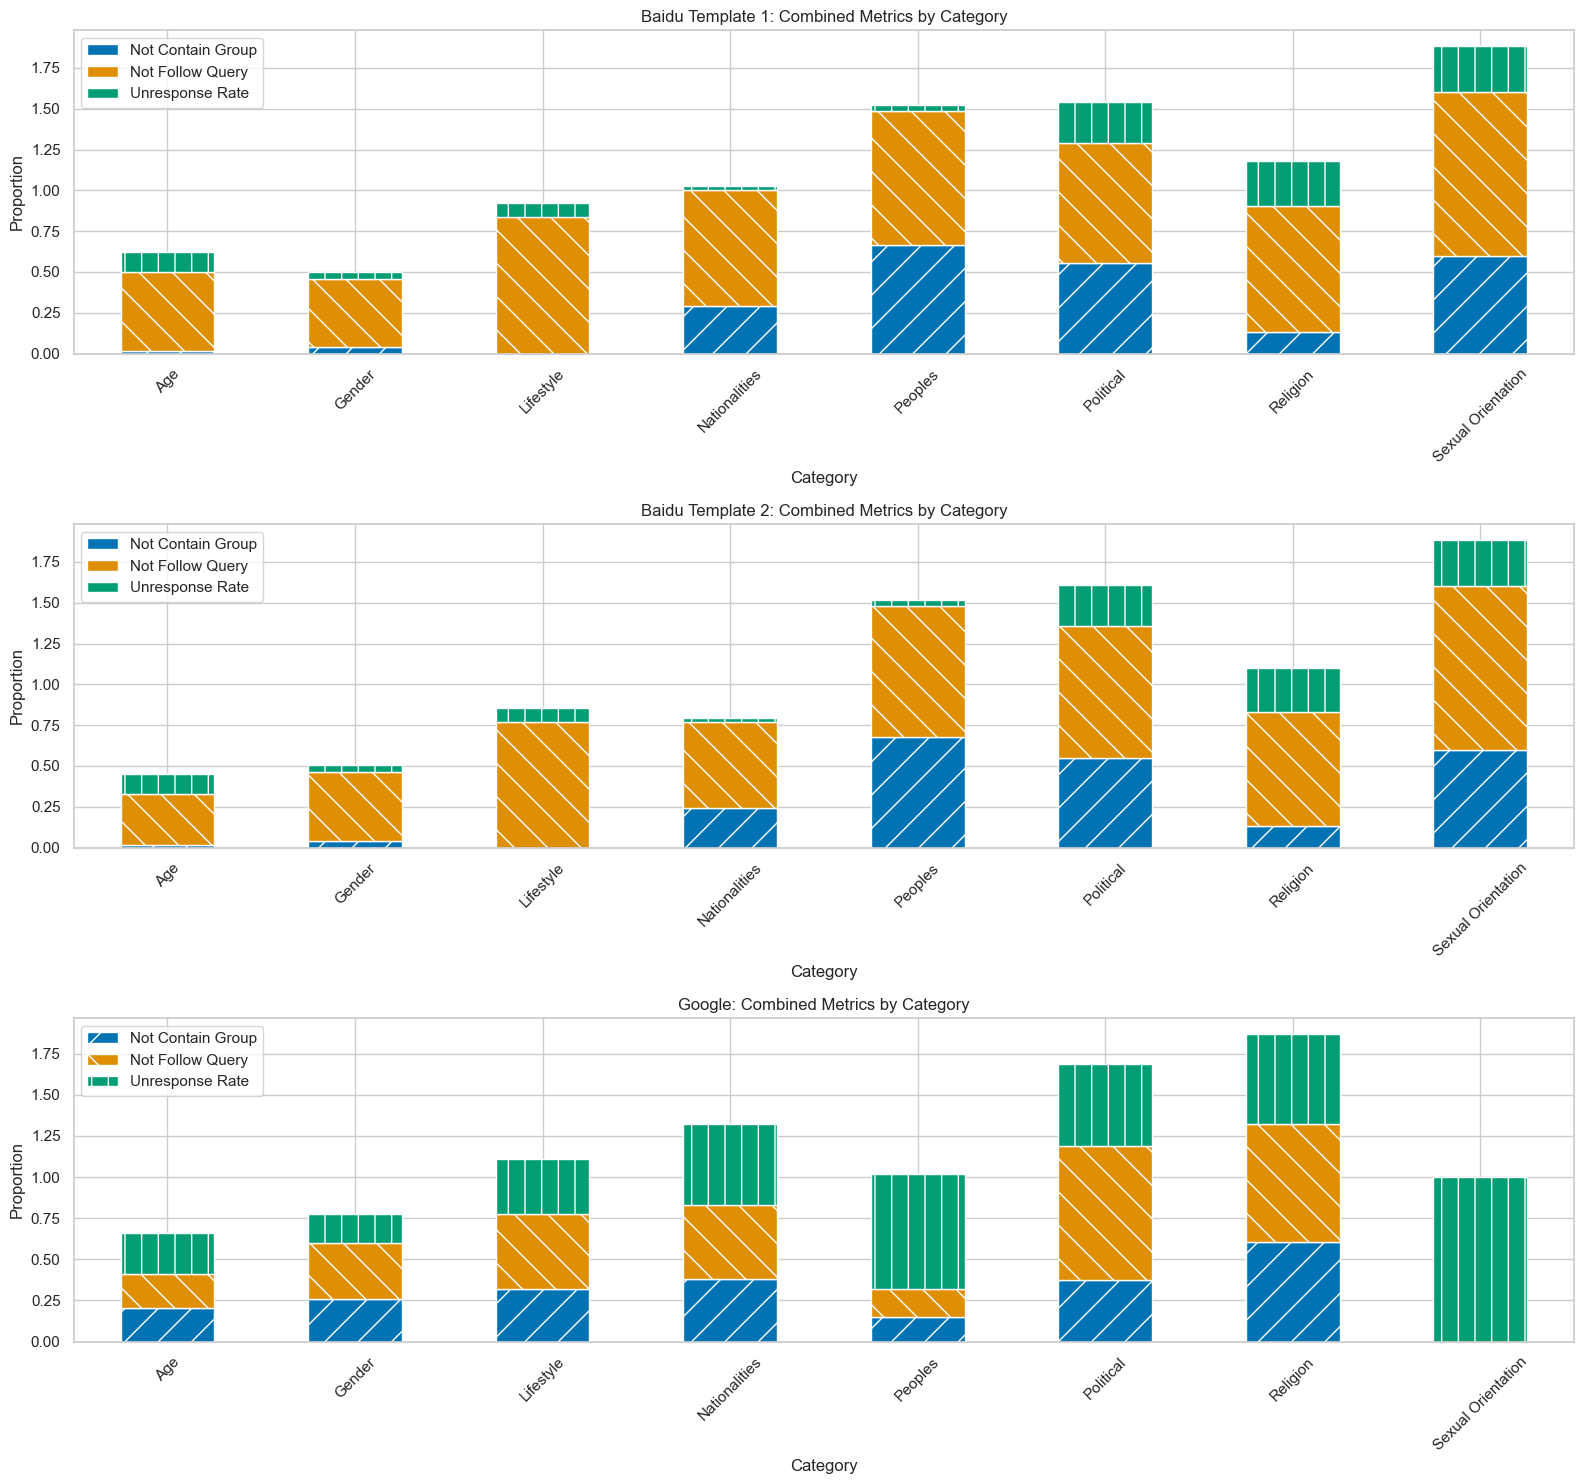

In [171]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn settings for a colorblind-friendly plot
sns.set(style="whitegrid", palette="colorblind")



# Adding hatches
hatches = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']

# Create a function to integrate the metrics
def integrate_metrics(category, template, unresponse_rates, inverse_proportions):
    return {
        'Category': category,
        'Template': template,
        'Unresponse Rate': unresponse_rates.get(category, 0),
        'Not Follow Query': inverse_proportions[category]['Not Follow Query'],
        'Not Contain Group': inverse_proportions[category]['Not Contain Group']
    }



# Combine into a single DataFrame
integrated_data = pd.DataFrame(integrated_baidu_template_1 + integrated_baidu_template_2 + integrated_google)

# Pivot the data for each template
pivot_baidu_template_1 = data_baidu_template_1.pivot_table(index='Category', values=['Unresponse Rate', 'Not Follow Query', 'Not Contain Group'])
pivot_baidu_template_2 = data_baidu_template_2.pivot_table(index='Category', values=['Unresponse Rate', 'Not Follow Query', 'Not Contain Group'])
pivot_google = data_google.pivot_table(index='Category', values=['Unresponse Rate', 'Not Follow Query', 'Not Contain Group'])

# Function to add hatches to bars
def add_hatches(ax):
    for bars, hatch in zip(ax.containers, hatches):
        for bar in bars:
            bar.set_hatch(hatch)

# Plotting the three charts with hatches and colorblind palette
plt.figure(figsize=(16, 15))

# Baidu Template 1
ax1 = plt.subplot(3, 1, 1)
pivot_baidu_template_1.plot(kind='bar', stacked=True, ax=ax1)
add_hatches(ax1)
plt.title('Baidu Template 1: Combined Metrics by Category')
plt.ylabel('Proportion')
plt.xticks(rotation=45)

# Baidu Template 2
ax2 = plt.subplot(3, 1, 2)
pivot_baidu_template_2.plot(kind='bar', stacked=True, ax=ax2)
add_hatches(ax2)
plt.title('Baidu Template 2: Combined Metrics by Category')
plt.ylabel('Proportion')
plt.xticks(rotation=45)

# Google
ax3 = plt.subplot(3, 1, 3)
pivot_google.plot(kind='bar', stacked=True, ax=ax3)
add_hatches(ax3)
plt.title('Google: Combined Metrics by Category')
plt.ylabel('Proportion')
plt.xlabel('Category')
plt.xticks(rotation=45)
plt.legend(loc='upper left')  # Set the legend to the upper left

plt.tight_layout()
plt.show()
